# Overview
This notebook reproduces a bug where `assembler.assemble_matrix_rhs()` returns and error if a `variable_filter` or `term_filter` is used when discretizing.


Status: Not able to create error in current setup (non-fractured domains).

Next step: Try with fractured domain.

In [19]:
import porepy as pp
import numpy as np

import scipy.sparse as sps

In [20]:
def create_domain(N=[2, 2]):
    """ Create a simple non-fractured domain."""
    #fracture = np.array([[0, 1], [0.5, 0.5]])
    gb = pp.meshing.cart_grid([], N, physdims=[1,1])
    return gb

In [21]:
def assign_data(gb, kw_flow):
    """ Assign default data to a diffusion operator."""
    
    tol = 1e-4
    for g, d in gb:
        
        # Assign dirichlet flow from left to right
        b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        if b_faces.size != 0:

            b_face_centers = g.face_centers[:, b_faces]
            b_inflow = b_face_centers[0, :] < tol
            b_outflow = b_face_centers[0, :] > 1-tol

            labels = np.array(["neu"] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)

            bc_val[b_faces[b_inflow]] = 1
        else:
            bc = pp.BoundaryCondition(g)
        
        specified_parameters = {'bc': bc, 'bc_values': bc_val}
        pp.initialize_default_data(g, d, 'flow', specified_parameters, kw_flow)
        
    return gb

In [22]:
# Create a simple non-fractured domain
gb = create_domain()

# We consider one equation and one variable ...
flow_keyword = 'flow'
gb = assign_data(gb, flow_keyword)

# Extract the 2-dimensional grid, for convenience.
g = gb.grids_of_dimension(2)[0]
data = gb.node_props(g)

flow_variable = 'pressure'

# ... with two terms. (Both diffusive)
flow_operator_key_1 = 'diffusion_1'
flow_operator_key_2 = 'diffusion_2'

flow_discretization_1 = pp.Tpfa(flow_keyword)
flow_discretization_2 = pp.Tpfa(flow_keyword)

# Set the discretization relations
data[pp.PRIMARY_VARIABLES] = {flow_variable: {"cells": 1}}
data[pp.DISCRETIZATION] = {
    flow_variable: {
        flow_operator_key_1: flow_discretization_1,
        flow_operator_key_2: flow_discretization_2,
    }
}

In [23]:
# Assemble the system
assembler = pp.Assembler(gb)
assembler.discretize()  # No term filter

# Solve the system:
A, b = assembler.assemble_matrix_rhs()
x = sps.linalg.spsolve(A, b)

assembler.distribute_variable(x)


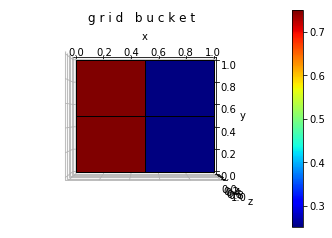

In [24]:
pp.plot_grid(gb, flow_variable)

# Summary
Above, we demonstrated an equation with two (identical) diffusive terms, e.g.:
$$- \nabla \cdot (K \nabla p) - \nabla \cdot (K \nabla p) = 0$$

# Next, apply a variable filter on discretization

In [25]:
assembler = pp.Assembler(gb)
assembler.discretize(term_filter=[flow_operator_key_1])

# Solve the system:
A, b = assembler.assemble_matrix_rhs()
x = sps.linalg.spsolve(A, b)

assembler.distribute_variable(x)